In [1]:
import pandas as pd
import re
import spacy
import nltk
from nltk.corpus import stopwords
from langdetect import detect


# Carica i dati
url = 'https://raw.githubusercontent.com/zfz/twitter_corpus/master/full-corpus.csv'
df = pd.read_csv(url)
data = df['TweetText'].tolist()

stop_words_dict = {
    'en': set(stopwords.words('english')),     # Inglese
}


# Funzione per pulire i tweet
def clean_tweet(text):
    text =re.sub(r'http\S+|https\S+', '', text) # Rimuovere link
    text = re.sub(r'@(\w+)', '', text)    # Rimuovere menzioni (@username)
    text = re.sub(r'#\w+', '', text) # Rimuovere hashtag
    text = re.sub(r'[^\w\s]', '', text)# Rimuovere qualsiasi carattere che non sia alfanumerico o uno spazio
    text = text.lower() 
    
    return text


# Rimozione stopwords
def remove_stopwords(text, lang):
    if lang in stop_words_dict:
        stop_words = stop_words_dict[lang]
        return ' '.join([word for word in text.split() if word.lower() not in stop_words])
    else:
        return ''

In [2]:
frase = "Yesterday sono andato al mercato to buy some fresh frutta and vegetables"
frase_cleaned = clean_tweet(frase)
l = detect(frase_cleaned)
frase_cleaned = remove_stopwords(frase_cleaned, l)
print(frase_cleaned)

yesterday sono andato al mercato buy fresh frutta vegetables


In [3]:
# Pre-elaborazione dei tweet
data_cleaned = []
for tweet in data:
    try:
        # Pulizia del tweet
        cleaned_tweet = clean_tweet(tweet)
        # Rileva la lingua
        lang = detect(cleaned_tweet)
        # Rimozione stop words in base alla lingua rilevata
        cleaned_tweet = remove_stopwords(cleaned_tweet, lang)
        if cleaned_tweet:  # Controlla se la stringa non è vuota
            data_cleaned.append(cleaned_tweet)
    except:
        continue  # Ignora tweet con errore nella rilevazione della lingua
print("Tweet originale:", data[:10])
print("Tweet pulito:", data_cleaned[:10])

Tweet originale: ['Now all @Apple has to do is get swype on the iphone and it will be crack. Iphone that is', '@Apple will be adding more carrier support to the iPhone 4S (just announced)', "Hilarious @youtube video - guy does a duet with @apple 's Siri. Pretty much sums up the love affair! http://t.co/8ExbnQjY", '@RIM you made it too easy for me to switch to @Apple iPhone. See ya!', 'I just realized that the reason I got into twitter was ios5 thanks @apple', "I'm a current @Blackberry user, little bit disappointed with it! Should I move to @Android or @Apple @iphone", 'The 16 strangest things Siri has said so far. I am SOOO glad that @Apple gave Siri a sense of humor! http://t.co/TWAeUDBp via @HappyPlace', 'Great up close & personal event @Apple tonight in Regent St store!', 'From which companies do you experience the best customer service aside from @zappos and @apple?', 'Just apply for a job at @Apple, hope they call me lol']
Tweet pulito: ['get swype iphone crack iphone', 'adding c

In [4]:
# Lemmatizzazione - Carica modelli per ogni lingua
nlp_models = {
    'en': spacy.load("en_core_web_sm"),
}

def lemmatize_text(text, lang):
    if lang in nlp_models:
        doc = nlp_models[lang](text)
        return ' '.join([token.lemma_ for token in doc if not token.is_stop])
    return text  # Restituisce il testo originale se non è supportato

# Lemmatizzazione dei dati puliti
data_lemmatized = []
for tweet in data_cleaned:
    try:
        lang = detect(tweet)
        lemmatized_tweet = lemmatize_text(tweet, lang)
        data_lemmatized.append(lemmatized_tweet)
    except:
        continue 
        
data_lemmatized = [tweet for tweet in data_lemmatized if isinstance(tweet, str) and tweet]
print("Tweet lemmatizzati:", data_lemmatized[:10])
print("Numero di tweet lemmatizzati:", len(data_lemmatized))

Tweet lemmatizzati: ['swype iphone crack iphone', 'add carrier support iphone 4s announce', 'hilarious video guy duet siri pretty much sums love affair', 'easy switch iphone ya', 'realize reason get twitter ios5 thank', 'm current user little bit disappointed', '16 strangest things siri said far sooo glad gave siri sense humor via', 'great close personal event tonight regent st store', 'company experience good customer service aside', 'apply job hope lol']
Numero di tweet lemmatizzati: 3304


In [5]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [6]:
from bertopic import BERTopic
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

b_topic_model = BERTopic(verbose=True)
b_topics, probabilities = b_topic_model.fit_transform(data_cleaned)

b_topic_model.get_topic_info()


2024-10-15 00:47:18.488671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 00:52:06,534 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/104 [00:00<?, ?it/s]

2024-10-15 00:53:26,903 - BERTopic - Embedding - Completed ✓
2024-10-15 00:53:26,904 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-10-15 00:54:05,406 - BERTopic - Dimensionality - Completed ✓
2024-10-15 00:54:05,408 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-10-15 00:54:05,879 - BERTopic - Cluster - Completed ✓
2024-10-15 00:54:05,963 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-10-15 00:54:06,197 - BERTopic - Representation - Completed ✓


Topic  Count                                    Name  \
0      -1   1325                  -1_new_rt_users_iphone   
1       0     89                    0_bitch_shit_say_wat   
2       1     85                       1_rt_rts_bird_ass   
3       2     80         2_twitter_tweet_retweets_tweets   
4       3     66        3_touchscreen_hand_surface_turns   
..    ...    ...                                     ...   
66     65     13  65_unwrapping_crossposted_galaxy_nexus   
67     66     12               66_ad_revenue_adwords_ads   
68     67     12                67_ipad_youve_love_ipads   
69     68     12          68_buzz_movement_charts_builds   
70     69     10     69_antitrust_lawsuits_1998_violated   

                                       Representation  \
0   [new, rt, users, iphone, one, phone, windows, ...   
1   [bitch, shit, say, wat, fuck, aint, wit, mind,...   
2   [rt, rts, bird, ass, best, tweeps, lil, able, ...   
3   [twitter, tweet, retweets, tweets, tweeting, s...   
4   [touchscreen, hand, surface, turns, touch, tur...   
..                                                ...   
66  [unwrapping, crossposted, galaxy, nexus, ice, ...   
67  [ad, revenue, adwords, ads, googles, advertise...   
68  [ipad, youve, love, ipads, dedicated, beta78, ...   
69  [buzz, movement, charts, builds, occupy, wall,...   
70  [antitrust, lawsuits, 1998, violated, 19th, be...   

                                  Representative_Docs  
0   [pls let us know need help w music marketing p...  
1   [mofucka dont give fuck express self ever da f...  
2   [rt better able see rts tomorrow tell lil blue...  
3   [rt adam levine takes aim evil fox news starts...  
4   [rt researchers want turn hand touchscreen rt,...  
..                                                ...  
66  [unwrapping ice cream sandwich galaxy nexus, u...  
67  [rt dont cast google adwords net wide mike mcc...  
68  [know youve gone overboard misread review ipad...  
69  [buzz builds occupy wall street movement chart...  
70  [bill gates testify novel v antitrust laws, vi...  

[71 rows x 5 columns]

In [7]:
b_topic_model.visualize_barchart(top_n_topics=10)

In [8]:
b_topic_model.visualize_topics()


In [9]:
from g2t.graph2topictm import evaluate

bert_topics = b_topic_model.get_topics()
td_score, cv_score, npmi_score = evaluate(data_cleaned, b_topics, bert_topics)
print(f"Diversità dei temi: {td_score}, Coerenza c_v: {cv_score}, Coerenza NPMI: {npmi_score}")

Diversità dei temi: 0.8718309859154929, Coerenza c_v: 0.7591546358541592, Coerenza NPMI: 0.0969971674928906


In [60]:
from g2t.graph2topictm import Graph2TopicTM
from g2t.graph2topictm import _calculate_topic_diversity, _calculate_cv_npmi

tm = Graph2TopicTM(dataset=data_cleaned, 
                embedding='princeton-nlp/unsup-simcse-bert-base-uncased')
g2T_prediction = tm.train()
g2T_topics = tm.get_topics()
print(f'Topics: {g2T_topics}')

# Evaluate
g2T_td = _calculate_topic_diversity(g2T_topics)
g2T_cv, g2T_npmi = _calculate_cv_npmi(data_cleaned, g2T_prediction, g2T_topics)

# Print the results
print(f"Topic Diversity Score: {g2T_td}")
print(f"Coherence (c_v) Score: {g2T_cv}")
print(f"Coherence (NPMI) Score: {g2T_npmi}")

Initialize G2T with num_topics=10, embedding=princeton-nlp/unsup-simcse-bert-base-uncased, dim_size=5, graph_method=greedy_modularity
---creating embedding---


3305it [06:44,  8.18it/s]


---Detect 77 Topcis---
====== Using TFIDF_IDFi ======
Topics: {0: [('hate', 0.007183396639913009), ('shit', 0.007118106134920867), ('fuck', 0.0064324375952579905), ('bitch', 0.004982995835547228), ('im', 0.004813331026049543), ('hell', 0.004745659911547973), ('bad', 0.004715055575917911), ('fucking', 0.004666242338029237), ('dont', 0.004427793625027732), ('damn', 0.003178886516894743)], 1: [('twitter', 0.02132666685562618), ('autopilot', 0.014218142706751464), ('gain', 0.013025731801129693), ('followers', 0.01146824096179868), ('put', 0.008078909298251506), ('let', 0.007988036415339754), ('facebook', 0.00630370779198884), ('siri', 0.005774351294890016), ('funniest', 0.005694435521579435), ('speech', 0.005641017829317121)], 2: [('iphone', 0.017048884677640996), ('ios5', 0.010771379641676612), ('apple', 0.010641825537739133), ('ipad', 0.008945799094953695), ('apps', 0.007703971372303506), ('update', 0.0074504860334686585), ('restore', 0.005883876283444279), ('ios', 0.005880215788703248),

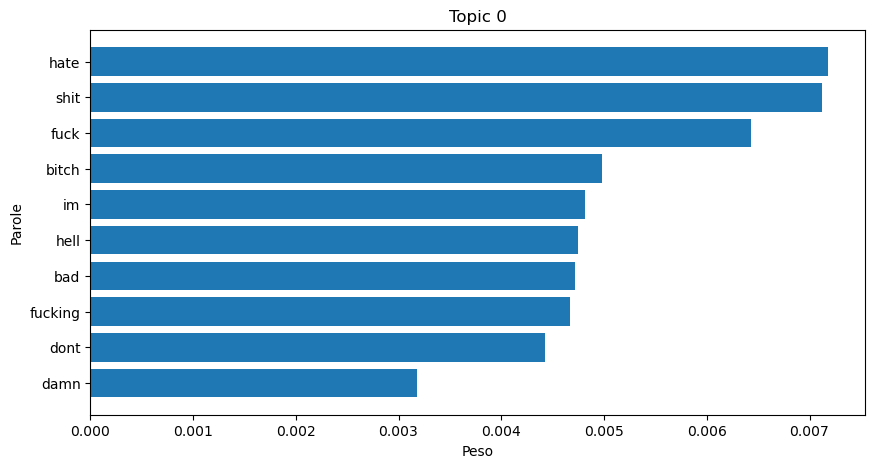

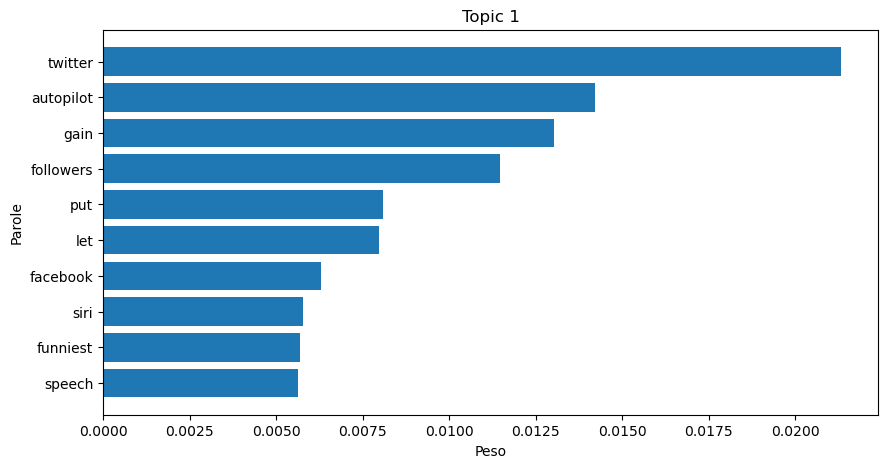

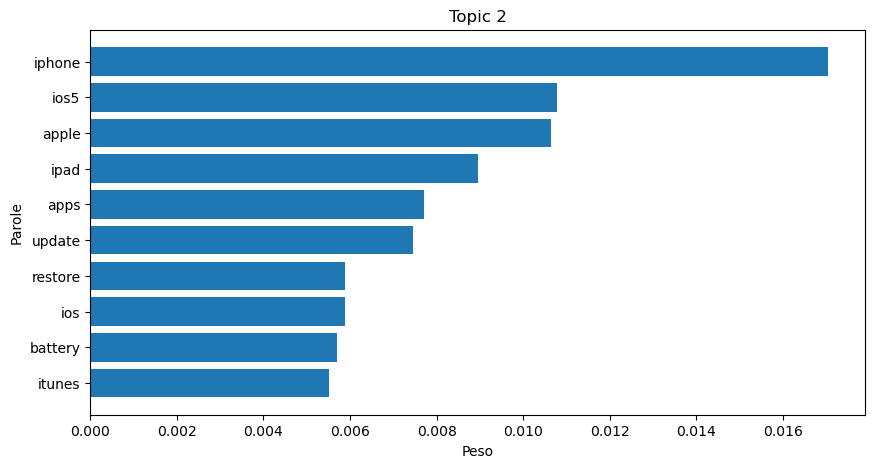

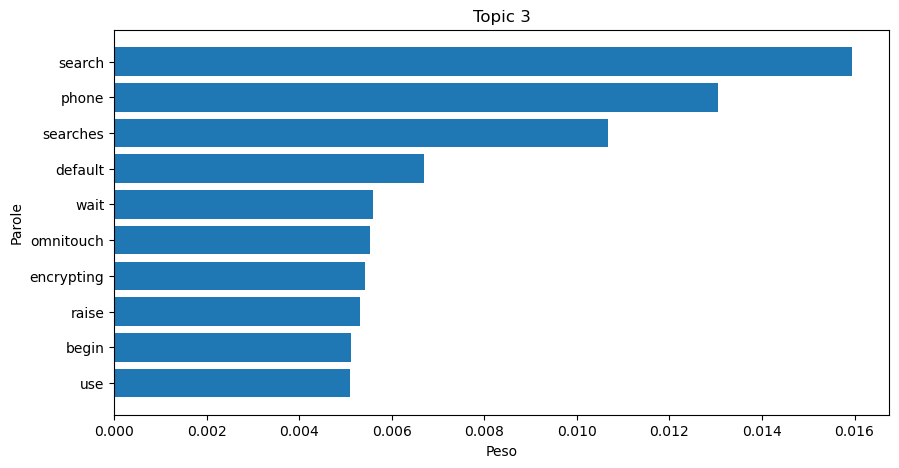

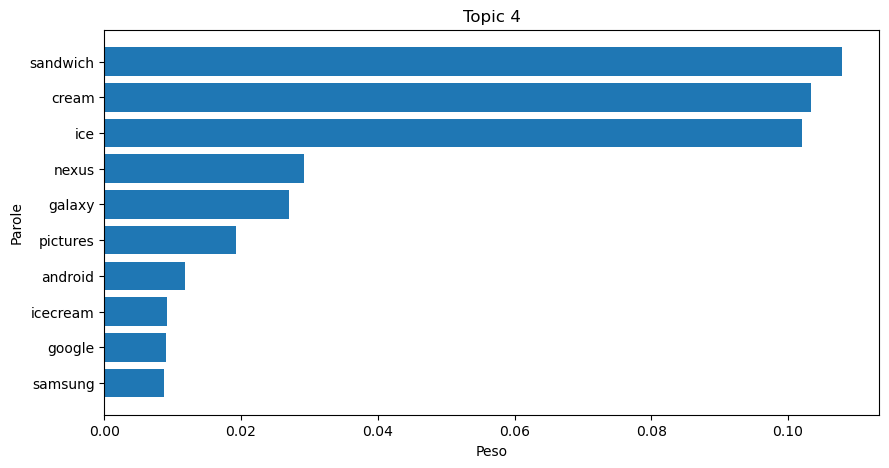

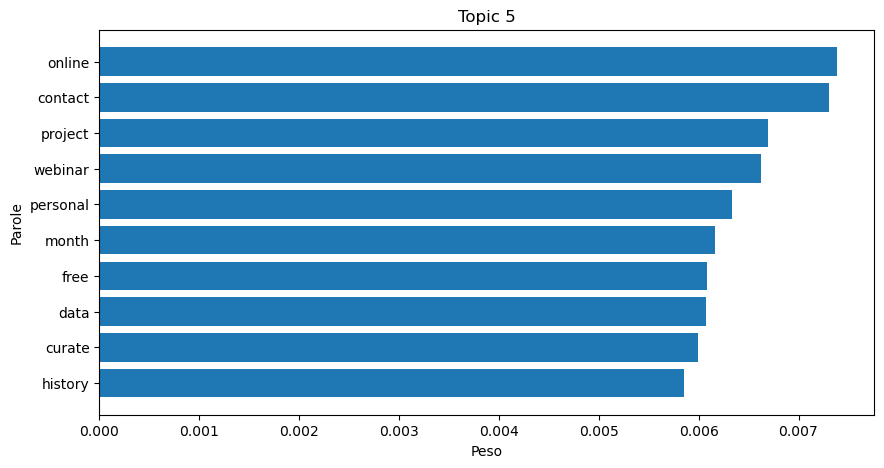

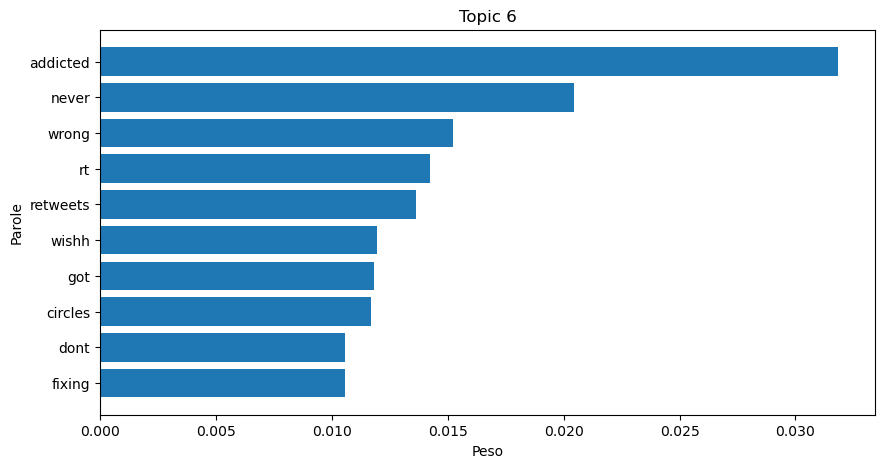

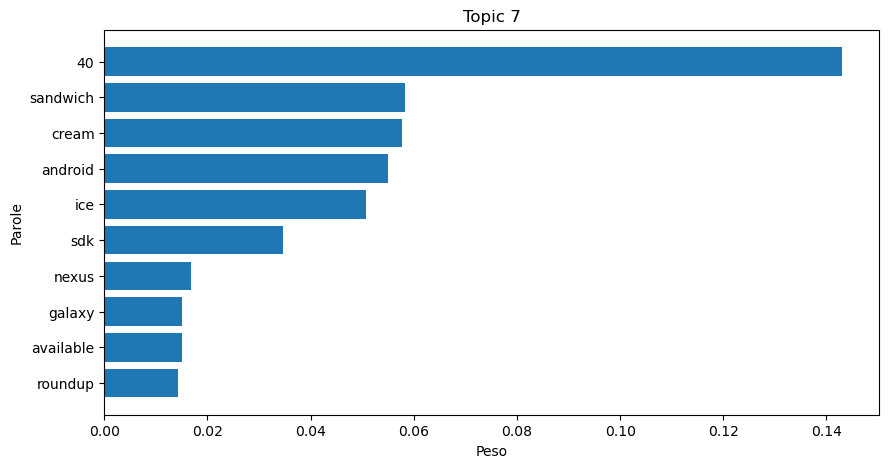

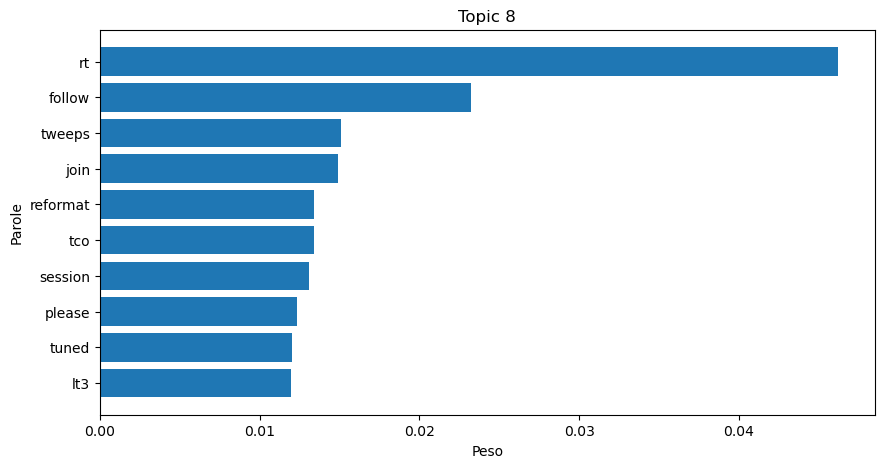

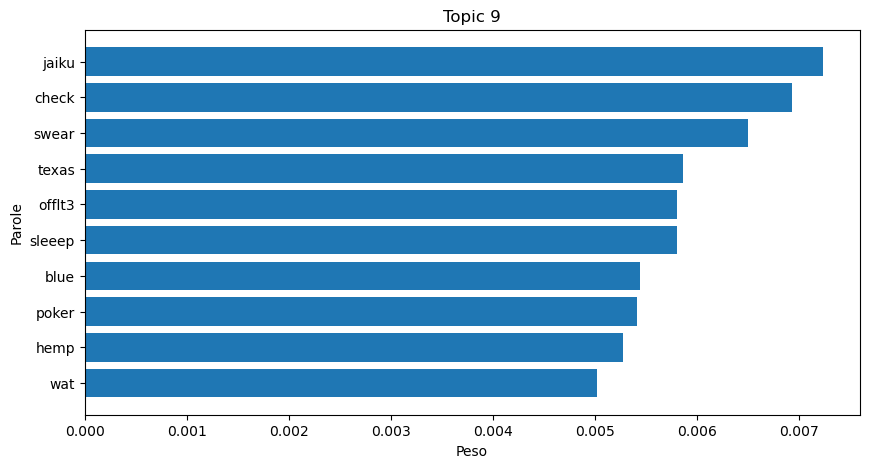

In [61]:
from plot_topics import plot_topics
plot_topics(g2T_topics)

In [12]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from pprint import pprint



# Funzione per convertire le frasi in parole
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


# Accedi correttamente alla colonna
data_words = list(sent_to_words(data_lemmatized))


# Visualizza i primi 30 termini del primo documento
print(data_words[:1][0][:30])



['swype', 'iphone', 'crack', 'iphone']


In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Creare il corpus BoW
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, 1), (1, 2), (2, 1)]
[(0,
  '0.024*"rt" + 0.011*"new" + 0.008*"app" + 0.007*"video" + 0.007*"go" + '
  '0.007*"galaxy" + 0.007*"nexus" + 0.007*"thank" + 0.006*"hour" + '
  '0.006*"phone"'),
 (1,
  '0.012*"microsoft" + 0.010*"rt" + 0.009*"new" + 0.009*"sandwich" + '
  '0.009*"cream" + 0.008*"ice" + 0.007*"search" + 0.007*"phone" + 0.006*"like" '
  '+ 0.005*"android"'),
 (2,
  '0.013*"time" + 0.012*"not" + 0.009*"think" + 0.008*"good" + 0.007*"steve" + '
  '0.007*"ballmer" + 0.006*"go" + 0.006*"google" + 0.006*"love" + '
  '0.006*"people"'),
 (3,
  '0.024*"phone" + 0.014*"rt" + 0.013*"new" + 0.008*"ballmer" + 0.008*"apple" '
  '+ 0.007*"thank" + 0.007*"use" + 0.007*"not" + 0.006*"go" + 0.005*"try"'),
 (4,
  '0.017*"rt" + 0.014*"new" + 0.013*"not" + 0.012*"cream" + 0.012*"ice" + '
  '0.012*"sandwich" + 0.011*"nexus" + 0.009*"get" + 0.009*"galaxy" + '
  '0.008*"google"'),
 (5,
  '0.023*"not" + 0.020*"iphone" + 0.010*"rt" + 0.008*"microsoft" + '
  '0.007*"good" + 0.006*"phone" + 0.006*"

In [14]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

# Prepara i dati per la visualizzazione
LDAvis_prepared = gensimvis.prepare(lda_model, corpus,id2word)

# Visualizza i dati preparati
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.110872 -0.022897       1        1  12.898339
7      0.012912  0.013085       2        1  11.050454
0     -0.039532  0.111928       3        1  10.692417
6     -0.034380 -0.039979       4        1  10.678626
8     -0.017836  0.064701       5        1  10.616409
2      0.107538  0.011046       6        1   9.518972
4     -0.036353 -0.006407       7        1   9.345244
5      0.050727 -0.070568       8        1   9.309391
3      0.088484  0.021942       9        1   8.469779
1     -0.020689 -0.082851      10        1   7.420369, topic_info=        Term        Freq       Total Category  logprob  loglift
1     iphone  175.000000  175.000000  Default  30.0000  30.0000
1693     ice  147.000000  147.000000  Default  29.0000  29.0000
1692   cream  153.000000  153.000000  Default  28.0000  28.0000
193      not  189.000000  189.000000  Default  27.0000  27.0000
64        rt  399.000000  399.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
251     need    5.700945   76.466344  Topic10  -5.6316   0.0047
1715  galaxy    5.861793  105.674374  Topic10  -5.6038  -0.2910
47     store    5.658975   95.472202  Topic10  -5.6390  -0.2247
1     iphone    6.007385  175.451786  Topic10  -5.5792  -0.7734
88       app    5.659171  105.124840  Topic10  -5.6389  -0.3209

[810 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
4419      6  0.613769  abbreviation
4419      7  0.306885  abbreviation
3396      1  0.764807          acct
4378      4  0.825603          adam
4341      1  0.690600        addict
...     ...       ...           ...
1539      9  0.614835           yet
4353      6  0.810266            yu
2834      5  0.819156    zuckerberg
3367      3  0.606375          zune
3367      9  0.303188          zune

[2015 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 1, 7, 9, 3, 5, 6, 4, 2])

In [15]:
predictions = []
for doc in corpus:
    topic_probs = lda_model.get_document_topics(doc)
    # Extract the topic with the highest probability
    # If no topic, assign -1
    if topic_probs:
        predictions.append(max(topic_probs, key=lambda x: x[1])[0])
    else:
        predictions.append(-1)

# Create a dictionary to map topics to words and their weights
lda_topics = {}
for topic_id in range(num_topics):
    words = lda_model.get_topic_terms(topic_id, topn=10)  # Get top 10 words for each topic
    lda_topics[topic_id] = [(id2word[word_id], weight) for word_id, weight in words]

td_lda, cv_lda, npmi_lda = evaluate(data_lemmatized, predictions, lda_topics)
print(f"Diversità dei temi: {td_lda}, Coerenza c_v: {cv_lda}, Coerenza NPMI: {npmi_lda}")

Diversità dei temi: 0.37, Coerenza c_v: 0.3843226916985329, Coerenza NPMI: -0.0012789688509185428


In [16]:
lda_model.get_document_topics(doc)

[(0, 0.5249671),
 (1, 0.025005074),
 (2, 0.025005037),
 (3, 0.02500325),
 (4, 0.025003828),
 (5, 0.025009446),
 (6, 0.02500664),
 (7, 0.025006706),
 (8, 0.025004549),
 (9, 0.27498838)]

In [17]:
import Bert_LDA
import importlib  # Importa importlib
importlib.reload(Bert_LDA) 

<module 'Bert_LDA' from '/Users/hongyuxu/Downloads/implementazioni Topic/Bert_LDA.py'>

In [18]:
from Bert_LDA import Topic_Model
from Bert_LDA import get_token_lists

token_lists = get_token_lists(data_lemmatized)
bertlda_m = Topic_Model(method='LDA_BERT')
bertlda_m.fit(data_lemmatized, token_lists)

Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches:   0%|          | 0/104 [00:00<?, ?it/s]

Getting vector representations for BERT. Done!
Fitting Autoencoder ...


2024-10-15 01:09:19.367415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fitting Autoencoder Done!
104/104 [==============================] - 0s 3ms/step
Clustering embeddings. Done!


Calculating UMAP projection...
Calculating the Umap projection. Done!


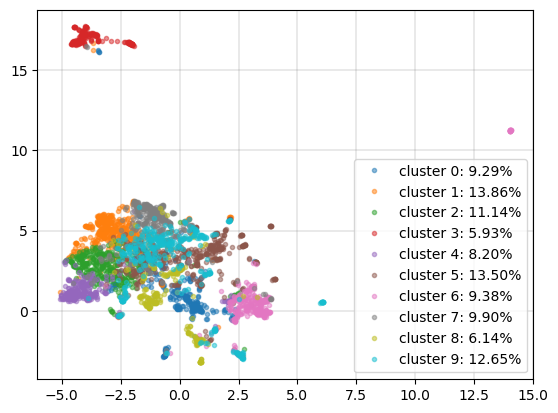

In [19]:
from Bert_LDA import visualize
visualize(bertlda_m)

Getting wordcloud for topic 0 ...


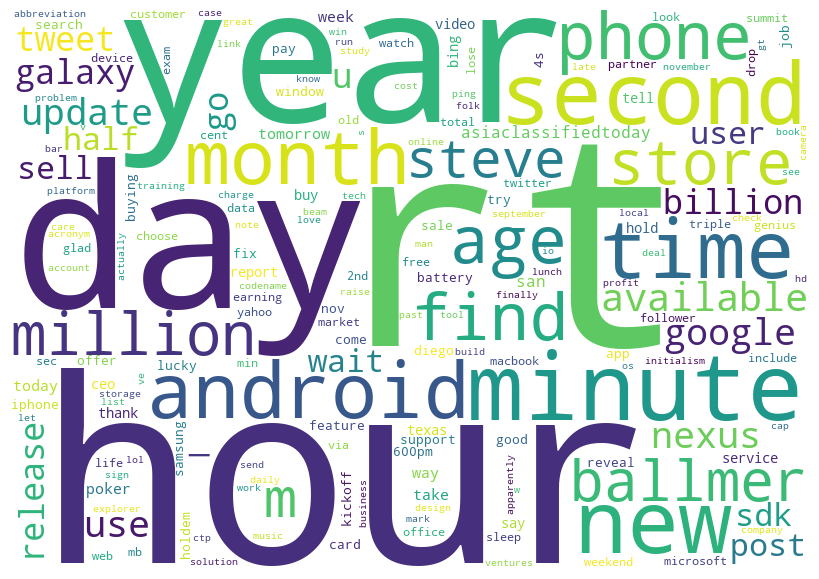

Getting wordcloud for topic 1 ...


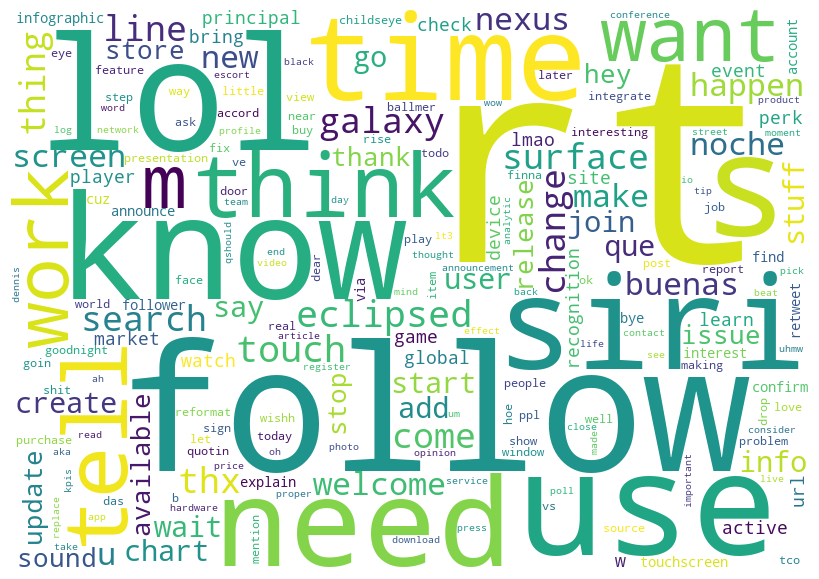

Getting wordcloud for topic 2 ...


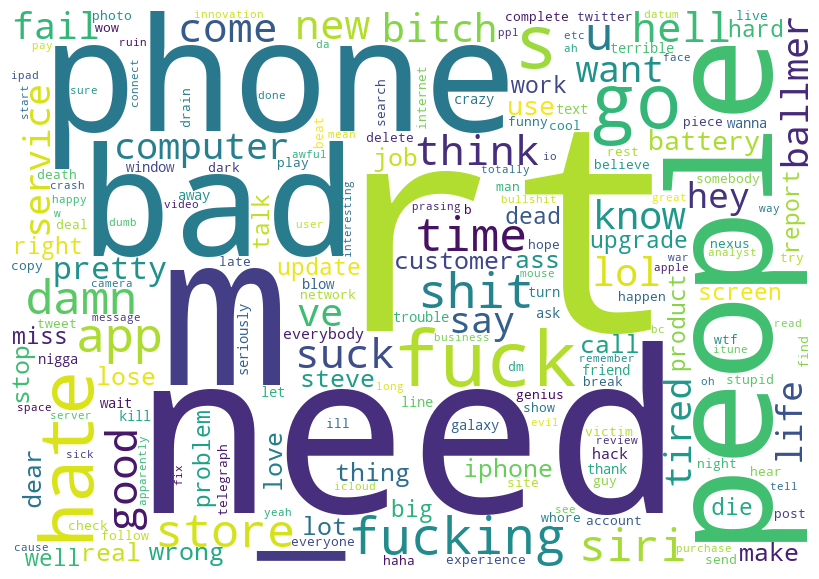

Getting wordcloud for topic 3 ...


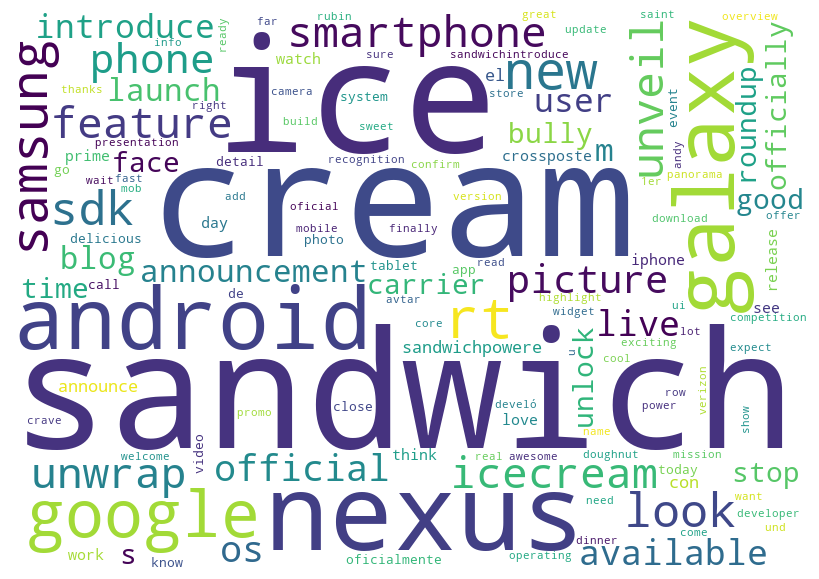

Getting wordcloud for topic 4 ...


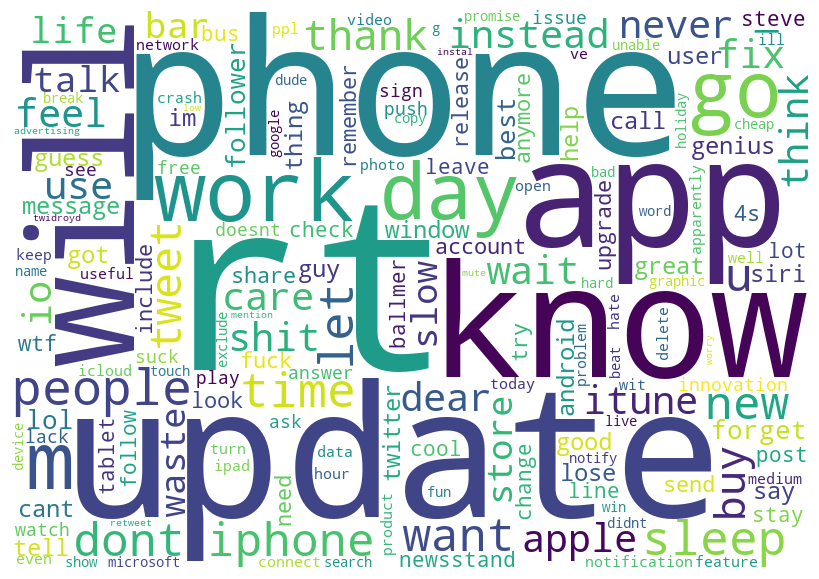

Getting wordcloud for topic 5 ...


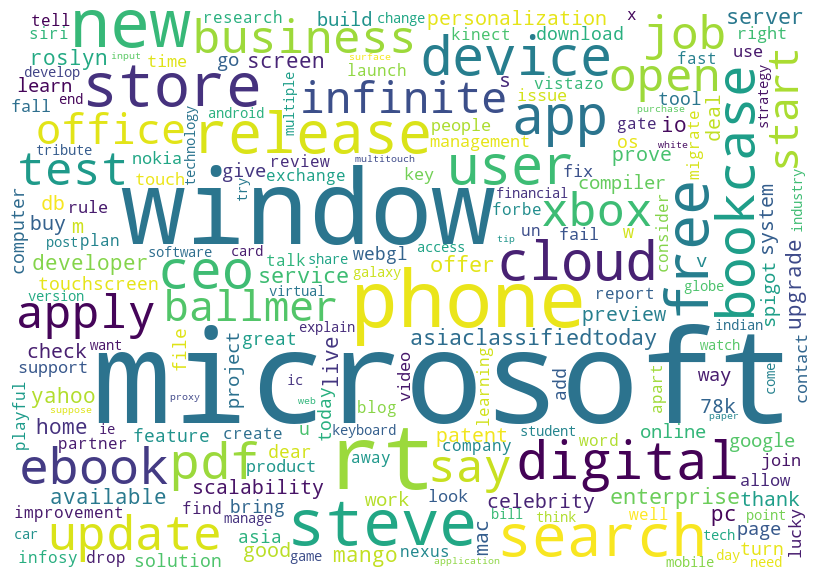

Getting wordcloud for topic 6 ...


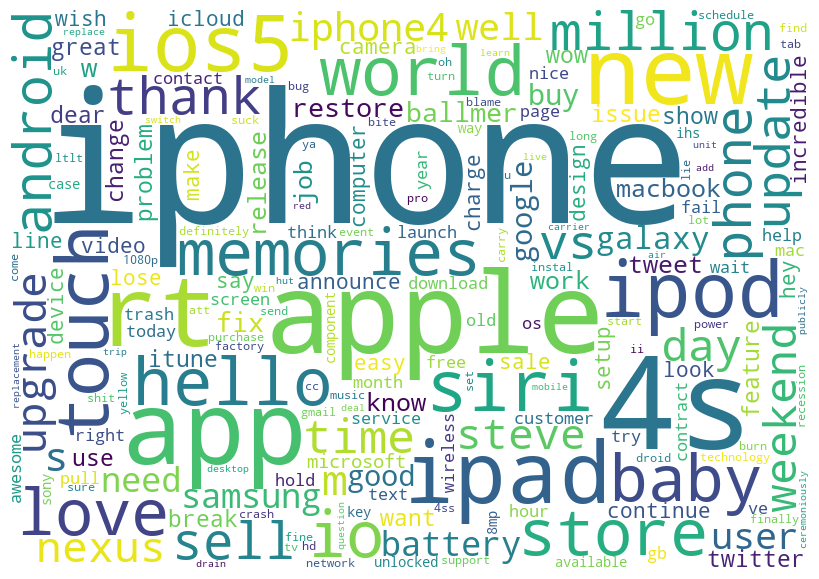

Getting wordcloud for topic 7 ...


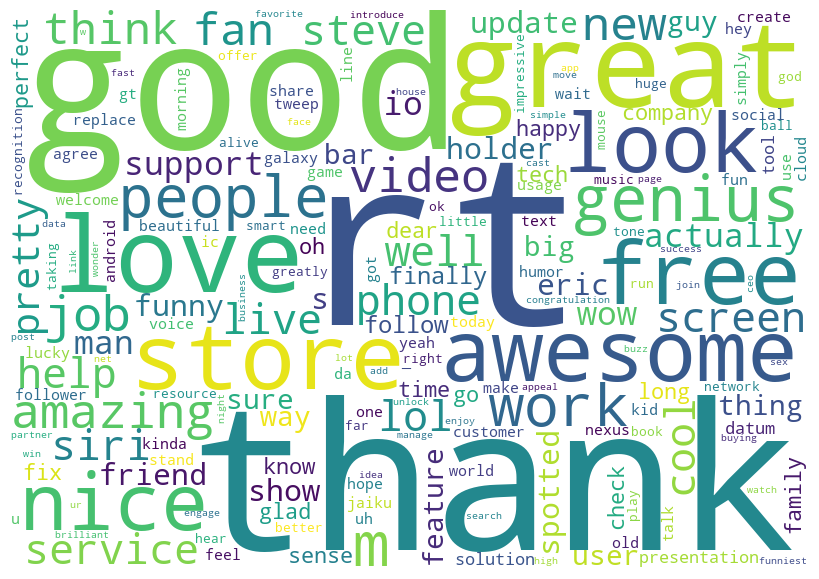

Getting wordcloud for topic 8 ...


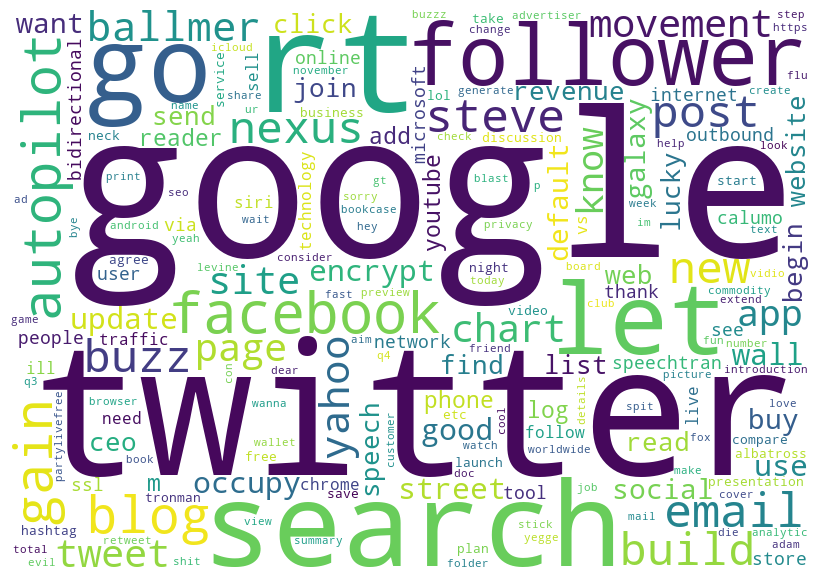

Getting wordcloud for topic 9 ...


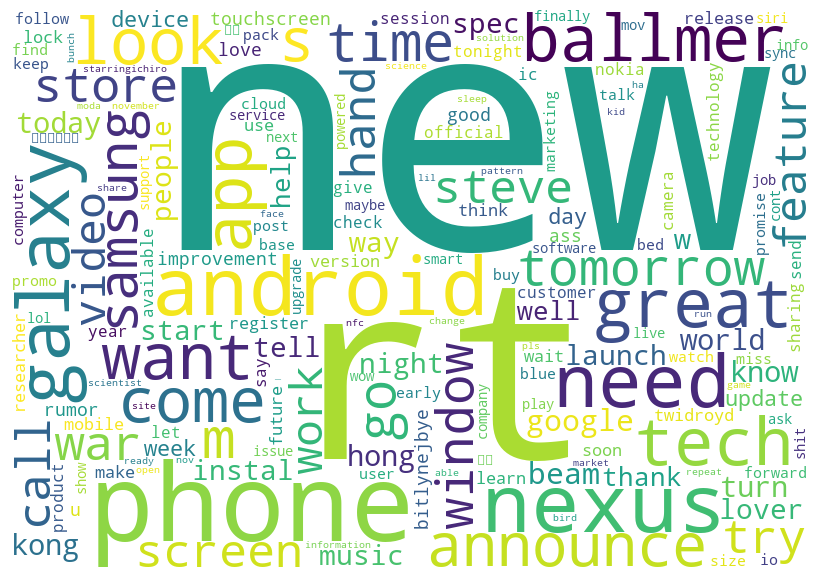

In [20]:
from Bert_LDA import get_wordcloud
for i in range(bertlda_m.k):
        get_wordcloud(bertlda_m, token_lists, i)

In [21]:
from Bert_LDA import get_topic_words

ldabert_dict= {}
ldabert_topics = get_topic_words(token_lists, bertlda_m.cluster_model.labels_)

for i in range(bertlda_m.k):
    ldabert_dict[i] = ldabert_topics[i]


print(ldabert_dict)

{0: ['rt', 'hour', '40', 'day', 'year', 'minute', 'new', 'second', 'android', 'time'], 1: ['rt', 'like', 'follow', 'lol', 'get', 'know', 'use', 's', 'siri', 'need'], 2: ['rt', 'need', 'm', 'phone', 'bad', 'people', '_', 'fuck', 'go', 'hate'], 3: ['sandwich', 'cream', 'ice', 'nexus', 'android', 'galaxy', '40', 'google', 'rt', 'new'], 4: ['not', 'rt', 'phone', 'like', 'update', 'know', 'app', 'will', 'work', 'm'], 5: ['microsoft', 'rt', 'window', 'phone', 'steve', 'new', 'store', 'free', 'search', 'windows'], 6: ['iphone', '4s', 'apple', 'app', 'rt', 'new', 'ipad', '4', 'ios5', 'ipod'], 7: ['rt', 'good', 'thank', 'great', 'love', 'store', 'awesome', 'free', 'like', 'nice'], 8: ['google', 'twitter', 'rt', 'search', 'go', 'let', 'follower', 'facebook', 'autopilot', 'gain'], 9: ['new', 'rt', 'phone', 'nexus', 'android', 'need', 'galaxy', 'get', 'great', 'tech']}


In [22]:
from g2t.graph2topictm import _calculate_topic_diversity
from Bert_LDA import get_coherence_cv
from Bert_LDA import get_coherence_npmi

td_ldaBERT = _calculate_topic_diversity(ldabert_dict)
cv_ldaBERT = get_coherence_cv(bertlda_m, token_lists)
npmi_ldaBERT = get_coherence_npmi(bertlda_m, token_lists)

print(f"Diversità dei temi: {td_ldaBERT}, Coerenza c_v: {cv_ldaBERT}, Coerenza NPMI: {npmi_ldaBERT}")

Diversità dei temi: 0.21, Coerenza c_v: 0.3722777560889591, Coerenza NPMI: -0.014966688099398865


In [62]:
data = {
    'LDA_BERT': [td_ldaBERT, cv_ldaBERT, npmi_ldaBERT],
    'Graph2Topic': [g2T_td, g2T_cv, g2T_npmi],
    'BERTopic': [td_score, cv_score, npmi_score],
    'LDA' : [td_lda, cv_lda, npmi_lda]
}

# Creazione del DataFrame e impostazione delle righe
df = pd.DataFrame(data, index=['td', 'cv', 'npmi'])

# Visualizzazione della tabella
df


LDA_BERT  Graph2Topic  BERTopic       LDA
td    0.210000     0.920000  0.871831  0.370000
cv    0.372278     0.624547  0.759155  0.384323
npmi -0.014967    -0.039865  0.096997 -0.001279

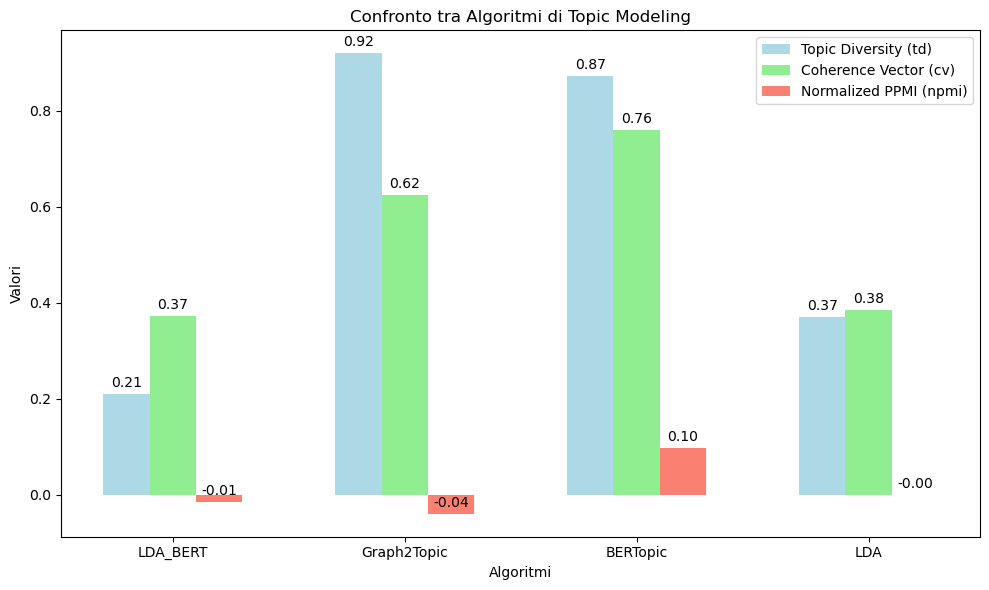

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Definisco i dati
algorithms = ['LDA_BERT', 'Graph2Topic', 'BERTopic', 'LDA']
td = [td_ldaBERT, g2T_td, td_score, td_lda]
cv = [cv_ldaBERT, g2T_cv, cv_score, cv_lda]
npmi = [npmi_ldaBERT, g2T_npmi, npmi_score, npmi_lda]

# Posizioni delle barre
x = np.arange(len(algorithms))

# Larghezza delle barre
width = 0.2

# Creazione della figura e degli assi
fig, ax = plt.subplots(figsize=(10, 6))

# Creazione delle barre
bars1 = ax.bar(x - width, td, width, label='Topic Diversity (td)', color='lightblue')
bars2 = ax.bar(x, cv, width, label='Coherence Vector (cv)', color='lightgreen')
bars3 = ax.bar(x + width, npmi, width, label='Normalized PPMI (npmi)', color='salmon')

# Aggiunta delle etichette e titolo
ax.set_xlabel('Algoritmi')
ax.set_ylabel('Valori')
ax.set_title('Confronto tra Algoritmi di Topic Modeling')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()

# Aggiunta delle etichette sopra le barre
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 punti sopra la barra
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Mostrare il grafico
plt.tight_layout()
plt.show()


In [64]:
import pandas as pd
from tabulate import tabulate


# Creazione del DataFrame per i topic di BERTopic escludendo il topic con ID -1
bertopic_df = pd.DataFrame(
    [(topic_id, ', '.join([keyword for keyword, _ in keywords])) for topic_id, keywords in bert_topics.items() if topic_id != -1],
    columns=['Topic ID', 'Keywords']
)

# Filtrare i primi 10 topic, inclusi quelli con ID da 0 a 9
bertopic_top10_df = bertopic_df.loc[bertopic_df['Topic ID'].isin(range(10))]

print("BERTopic Topics:")
print(tabulate(bertopic_top10_df, headers='keys', tablefmt='pretty', showindex=False))


BERTopic Topics:
+----------+---------------------------------------------------------------------------------------+
| Topic ID |                                       Keywords                                        |
+----------+---------------------------------------------------------------------------------------+
|    0     |             bitch, shit, say, wat, fuck, aint, wit, mind, niggas, always              |
|    1     |                 rt, rts, bird, ass, best, tweeps, lil, able, blue, da                 |
|    2     |      twitter, tweet, retweets, tweets, tweeting, see, wishh, funniest, fun, shit      |
|    3     |  touchscreen, hand, surface, turns, touch, turn, researchers, omnitouch, body, want   |
|    4     |      siri, 4s, forbes, suppose, setup, iphone, asked, tweets, bought, connecting      |
|    5     |       ios5, ios, update, itunes, feature, upgrade, ipad, easter, eggs, updating       |
|    6     | sandwich, ice, cream, officially, exciting, announces, dinner

In [65]:
g2t_df = pd.DataFrame(
    [(topic_id, ', '.join([keyword for keyword, _ in keywords])) for topic_id, keywords in g2T_topics.items()],
    columns=['Topic ID', 'Keywords'])
print("G2T Topics:")
print(tabulate(g2t_df, headers='keys', tablefmt='pretty', showindex=False))

G2T Topics:
+----------+-----------------------------------------------------------------------------------+
| Topic ID |                                     Keywords                                      |
+----------+-----------------------------------------------------------------------------------+
|    0     |            hate, shit, fuck, bitch, im, hell, bad, fucking, dont, damn            |
|    1     |  twitter, autopilot, gain, followers, put, let, facebook, siri, funniest, speech  |
|    2     |      iphone, ios5, apple, ipad, apps, update, restore, ios, battery, itunes       |
|    3     | search, phone, searches, default, wait, omnitouch, encrypting, raise, begin, use  |
|    4     | sandwich, cream, ice, nexus, galaxy, pictures, android, icecream, google, samsung |
|    5     |  online, contact, project, webinar, personal, month, free, data, curate, history  |
|    6     |      addicted, never, wrong, rt, retweets, wishh, got, circles, dont, fixing      |
|    7     |     4

In [66]:
lda_df = pd.DataFrame(
    [(topic_id, ', '.join([keyword for keyword, _ in keywords])) for topic_id, keywords in lda_topics.items()],
    columns=['Topic ID', 'Keywords'])
print("LDA Topics:")
print(tabulate(lda_df, headers='keys', tablefmt='pretty', showindex=False))

LDA Topics:
+----------+-------------------------------------------------------------------------+
| Topic ID |                                Keywords                                 |
+----------+-------------------------------------------------------------------------+
|    0     |       rt, new, app, video, go, galaxy, nexus, thank, hour, phone        |
|    1     | microsoft, rt, new, sandwich, cream, ice, search, phone, like, android  |
|    2     |    time, not, think, good, steve, ballmer, go, google, love, people     |
|    3     |        phone, rt, new, ballmer, apple, thank, use, not, go, try         |
|    4     |     rt, new, not, cream, ice, sandwich, nexus, get, galaxy, google      |
|    5     |   not, iphone, rt, microsoft, good, phone, app, ballmer, steve, time    |
|    6     | rt, microsoft, android, new, not, like, phone, store, sandwich, window  |
|    7     |       new, rt, iphone, phone, app, get, window, not, know, nexus        |
|    8     |    iphone, rt, new

In [67]:
ldabert_df = pd.DataFrame(
    [(topic_id, ', '.join(keywords)) for topic_id, keywords in ldabert_dict.items()],
    columns=['Topic ID', 'Keywords']
)

print("LDA-BERT Topics:")
print(tabulate(ldabert_df, headers='keys', tablefmt='pretty', showindex=False))

LDA-BERT Topics:
+----------+---------------------------------------------------------------------------+
| Topic ID |                                 Keywords                                  |
+----------+---------------------------------------------------------------------------+
|    0     |        rt, hour, 40, day, year, minute, new, second, android, time        |
|    1     |           rt, like, follow, lol, get, know, use, s, siri, need            |
|    2     |            rt, need, m, phone, bad, people, _, fuck, go, hate             |
|    3     |     sandwich, cream, ice, nexus, android, galaxy, 40, google, rt, new     |
|    4     |          not, rt, phone, like, update, know, app, will, work, m           |
|    5     |  microsoft, rt, window, phone, steve, new, store, free, search, windows   |
|    6     |           iphone, 4s, apple, app, rt, new, ipad, 4, ios5, ipod            |
|    7     |      rt, good, thank, great, love, store, awesome, free, like, nice       |
|   

In [68]:
# Genera l'HTML per ciascun DataFrame
bertopic_html = bertopic_top10_df.to_html(index=False, classes='table', border=0)
g2t_html = g2t_df.to_html(index=False, classes='table', border=0)
lda_html = lda_df.to_html(index=False, classes='table', border=0)
ldabert_html = ldabert_df.to_html(index=False, classes='table', border=0)

# Scrivi l'HTML in un file con il CSS incluso
with open('combined_topics_tables.html', 'w') as f:
    f.write('''
    <!DOCTYPE html>
    <html lang="it">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Tabella Modelli</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                background-color: #f4f4f9;
                margin: 20px;
            }
            table {
                width: auto;
                border-collapse: collapse;
                margin: 20px 0;
                font-size: 0.9em;
                background-color: white;
            }
            th, td {
                border: 1px solid #dddddd;
                padding: 10px 15px;
                text-align: left;
            }
            th {
                background-color: #f0f0f0;
                font-weight: bold;
                text-align: center;
            }
            .table th {
                background-color: #d9e2f3;
            }
            .keywords {
                font-size: 0.9em;
                color: #555;
            }
            tr:nth-child(even) {
                background-color: #f9f9f9;
            }
            tr:nth-child(odd) {
                background-color: #ffffff;
            }
            h2 {
                color: #333;
            }
            h3 {
                color: #333;
                margin-top: 40px; /* Spaziatura tra le intestazioni */
            }
        </style>
    </head>
    <body>
    <h2>Tabella Modelli</h2>

    <h3>BERTopic</h3>
    ''')

    f.write(bertopic_html)
    f.write('''
    <h3>G2T</h3>
    ''')
    f.write(g2t_html)
    f.write('''
    <h3>LDA</h3>
    ''')
    f.write(lda_html)
    f.write('''
    <h3>LDA-BERT</h3>
    ''')
    f.write(ldabert_html)

    f.write('''
    </body>
    </html>
    ''')
